In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
print("Version: ", tf.__version__)

# Preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Model
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, Embedding, Dropout
from tensorflow.keras.models import Sequential

# Loading
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

os.chdir("../")
from lib.utils import load_data
os.chdir("notebooks/")

Version:  1.14.0


In [2]:
df = load_data()
df.head()

,Body,Bias,cleaned_body
0,Abortion rights advocates have asked the U.S. ...,1.67,abortion right advocate asked u supreme court ...
1,A federal appeals court rejected the most dire...,0.67,federal appeal court rejected direct constitut...
2,As part of the Trump administration's effort t...,-2.75,part trump administration effort slow migrant ...
3,"President Donald Trump and ""the Trump of the T...",-4.33,president donald trump trump tropic brazilian ...
4,"U.S Senator Elizabeth Warren, who is competing...",-10.00,u senator elizabeth warren competing democrati...


## Data Preprocessing

In [3]:
df.loc[df['Bias'] <= 0, 'Bias'] = 0
df.loc[df['Bias'] > 0, 'Bias'] = 1

In [4]:
df = df.drop(columns=['Body'])

In [5]:
train_set, testval_set = train_test_split(df)
val_set, test_set = train_test_split(testval_set, train_size=0.5)

X_train = train_set['cleaned_body']
X_val = val_set['cleaned_body']
X_test = test_set['cleaned_body']

y_train = train_set['Bias'].values
y_val = val_set['Bias'].values
y_test = test_set['Bias'].values

In [6]:
# Tokenizing
MAX_VOCAB_SIZE = 20000

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [7]:
# Padding sequences
#X_train_pad = pad_sequences(sequences_train)

#MAX_LEN = X_train_pad.shape[1]
MAX_LEN = 2000

X_train_pad = pad_sequences(sequences_train, maxlen=MAX_LEN)
X_val_pad = pad_sequences(sequences_val, maxlen=MAX_LEN)
X_test_pad = pad_sequences(sequences_test, maxlen=MAX_LEN)

print('Training shape: ', X_train_pad.shape)
print('Validation shape: ', X_val_pad.shape)
print('Testing shape: ', X_test_pad.shape)

Training shape:  (1256, 2000)
Validation shape:  (209, 2000)
Testing shape:  (210, 2000)


In [8]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by the batch size
    """

    no_of_rows_drop = mat.shape[0] % batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

## Creating the Model

In [9]:
V = len(tokenizer.word_index) # Corpus length
D = min(600, round(1.6 * V ** .56)) # Dimensionality of Embedding layer

###############################################################################
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.

config_proto = tf.ConfigProto()
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
session = tf.Session(config=config_proto)
set_session(session)
###############################################################################

model = Sequential()
        
model.add(Input(shape=(X_train_pad.shape[1],)))
model.add(Embedding(V + 1, D))

model.add(LSTM(64, return_sequences=True))
#model.add(Dropout(0.2))

#model.add(LSTM(128, return_sequences=True))
#model.add(Dropout(0.2))

#model.add(LSTM(64))
#model.add(Dropout(0.2))

model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
EPOCHS = 3
BATCH_SIZE = 64

X_train_pad = trim_dataset(X_train_pad, BATCH_SIZE)
y_train = trim_dataset(y_train, BATCH_SIZE)
#X_val_pad = trim_dataset(X_val_pad, BATCH_SIZE)
#y_val = trim_dataset(y_val, BATCH_SIZE)

print('Training...')
r = model.fit(X_train_pad, 
              y_train, 
              epochs = EPOCHS, 
              batch_size = BATCH_SIZE,
              validation_data=(X_val_pad, y_val))

Training...
Train on 1216 samples, validate on 209 samples
Epoch 1/3
1216/1216 [==============================] - 174s 143ms/sample - loss: 0.6194 - acc: 0.6834 - val_loss: 0.6190 - val_acc: 0.6794
Epoch 2/3
1216/1216 [==============================] - 194s 159ms/sample - loss: 0.5632 - acc: 0.6875 - val_loss: 0.5979 - val_acc: 0.6938
Epoch 3/3
1216/1216 [==============================] - 216s 178ms/sample - loss: 0.4451 - acc: 0.7566 - val_loss: 0.6485 - val_acc: 0.7177


## Plotting results

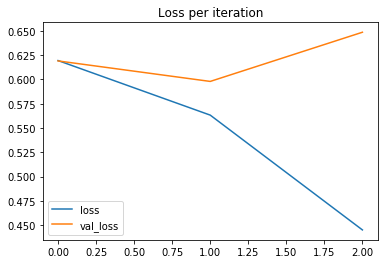

In [12]:
plt.title('Loss per iteration')
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

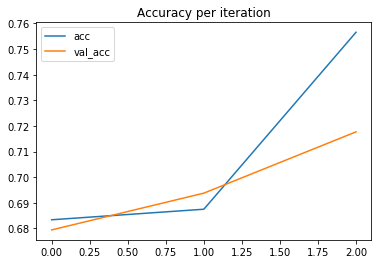

In [13]:
plt.title('Accuracy per iteration')
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()

## Saving Model

In [15]:
model_name = '../saved_models/lstm_{layer_num}_{batch_size}_{epochs}'.format(layer_num=1,
                                                                             batch_size=BATCH_SIZE,
                                                                             epochs=EPOCHS)

#model.save(model_name + ".h5")

# serialize model to JSON
model_json = model.to_json()
with open(model_name + ".json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights(model_name + ".h5")

print("Saved model to disk")

Saved model to disk


## Loading Model

In [23]:
#model = load_model("../saved_models/lstm_1_64_4.h5")

json_file = open('../saved_models/lstm_1_64_3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# load weights into new model
model.load_weights("../saved_models/lstm_1_64_3.h5")
print("Loaded model from disk")

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Loaded model from disk


## Evaluating

In [24]:
model.evaluate(X_test_pad, y_test)

210/210 [==============================] - 8s 37ms/sample - loss: 0.7739 - acc: 0.6762


[0.7738786981219337, 0.6761905]

In [25]:
y_pred = model.predict_classes(X_test_pad)
y_pred = [i for sublist in y_pred for i in sublist]

In [26]:
roc_auc_score(y_test, y_pred)

0.575